### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
#sc.stop()

findspark.init()

from pyspark import SparkContext
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])
#sc.stop()
from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions



Populating the interactive namespace from numpy and matplotlib


In [2]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BBSBSBSB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df=sqlContext.read.parquet(filename)
print df.count()
df.show(30)

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12493
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    400.8| 47.4306| -94.0586|       TMAX|USC00219059|    20|[00 7E 40 D2 00 D...|1898.0|BBSBSBSB|
|    400.8| 47.4306| -94.0586|       TMAX|USC00219059|    31|[30 D4 80 D4 30 D...|1900.0|BBSBSBSB|
|    400.8| 47.4306| -94.0586|       TMAX|USC00219059|    28|[00 7E 00 7E A0 D...|1901.0|BBSBSBSB|
|    400.8| 47.4306| -94.0586|       TMAX|USC00219059|    32|[00 7E 00 7E 00 7...|1902.0|BBSBSBSB|
|    400.8| 47.4306| -94.0586|       TMAX|USC00219059|    28|[00 00 00 D3 30 D...|1903.0|BBSBSBSB|
|    400.8| 47.4306| -94.0586|       TMAX|USC00219059|    31|[E0 D0 80 D4 E0 D...|1905.0|BBSBSBSB|
|    400.8| 47.4306| -94.0586|       T

### Select data for a particular station and measurement type

In [26]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USC00219059')
# Query1="SELECT DISTINCT station, year, vector FROM weather\n\tWHERE measurement='TMIN'"

Query2 = "SELECT * FROM (SELECT  station, year, vector, ROW_NUMBER() OVER(PARTITION BY station ORDER BY year) rn FROM weather WHERE measurement = 'PRCP') a WHERE rn = 1"

print Query
df1 = sqlContext.sql(Query)
df2 = sqlContext.sql(Query2)

print df1.count(),'rows'
df2.show(2)
# df2.show(10)
rows=df2.rdd.map(lambda row:unpackArray(row['vector'],np.float16))
T=np.vstack(rows.collect())
T=T/10.  # scaling to make the temperature be in centingrates
print T

shape(T)



SELECT * FROM weather
	WHERE measurement='TMAX' and station='USC00219059'
85 rows
+-----------+------+--------------------+---+
|    station|  year|              vector| rn|
+-----------+------+--------------------+---+
|USC00215989|2009.0|[00 00 00 00 00 0...|  1|
|USC00210643|1900.0|[80 4A 00 00 00 0...|  1|
+-----------+------+--------------------+---+
only showing top 2 rows

[[  0.           0.           0.         ...,   0.           0.           0.        ]
 [  1.29980469   0.           0.         ...,   0.           0.           0.        ]
 [  0.30004883   0.           0.         ...,          nan          nan
           nan]
 ..., 
 [  0.           0.           0.         ...,   0.           0.           0.        ]
 [  0.           0.           0.         ...,   2.5          3.80078125
    6.3984375 ]
 [  0.           0.          10.703125   ...,   0.                  nan
    0.        ]]


(92, 365)

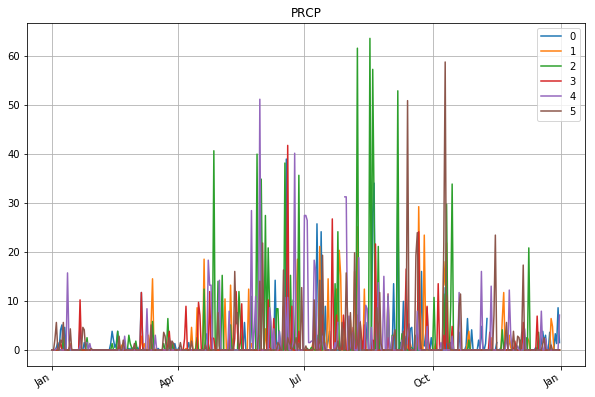

In [28]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[30:36,:].transpose(),fig,ax,title='PRCP')

#title('A sample of graphs');

In [5]:
sqlContext.registerDataFrameAsTable(df,'weather')
# Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USW00093139')
#Query1="SELECT DISTINCT station, year, vector FROM weather\n\tWHERE measurement='TMAX'"

Query2 = "SELECT * FROM (SELECT  station, year, vector, ROW_NUMBER() OVER(PARTITION BY station ORDER BY year) rn FROM weather WHERE measurement = 'PRCP') a WHERE rn = 1"

print Query2
# df1 = sqlContext.sql(Query1)
df2 = sqlContext.sql(Query2)

print df2.count(),'rows'
# df1.show(2)
df2.show(10)
rows=df2.rdd.map(lambda row:unpackArray(row['vector'],np.float16))
temp = rows.flatMap(lambda r: r).map(lambda r: (r,1)).reduceByKey(lambda x,y: x+y).map(lambda (k,v):(v,k)).sortByKey(False)
print(temp.take(10))
T=np.vstack(rows.collect())
T=T/10.  # scaling to make the temperature be in centingrates
print T

shape(T)

SELECT * FROM (SELECT  station, year, vector, ROW_NUMBER() OVER(PARTITION BY station ORDER BY year) rn FROM weather WHERE measurement = 'PRCP') a WHERE rn = 1
92 rows
+-----------+------+--------------------+---+
|    station|  year|              vector| rn|
+-----------+------+--------------------+---+
|USC00215989|2009.0|[00 00 00 00 00 0...|  1|
|USC00210643|1900.0|[80 4A 00 00 00 0...|  1|
|USC00214103|1961.0|[00 42 00 00 00 0...|  1|
|CA006027825|1964.0|[00 7E 00 7E 00 7...|  1|
|USC00219015|1899.0|[00 00 00 00 00 0...|  1|
|USC00213303|1916.0|[00 00 E0 55 00 0...|  1|
|USC00214233|1909.0|[00 7E 00 7E 00 7...|  1|
|CA006020559|1979.0|[00 00 00 40 00 0...|  1|
|USC00210754|1941.0|[C0 51 F0 57 00 0...|  1|
|USC00210746|1931.0|[00 00 00 00 00 0...|  1|
+-----------+------+--------------------+---+
only showing top 10 rows

[(23537, 0.0), (704, 5.0), (552, 3.0), (476, 13.0), (454, 8.0), (441, 10.0), (380, 25.0), (306, 20.0), (281, 15.0), (258, 18.0)]
[[  0.           0.           0.  

(92, 365)

In [6]:
print(temp.count())

1341


In [7]:
tmp=temp.collect()

In [8]:
list1= [ x[0] for x in tmp ]
list2= [ x[1] for x in tmp ]

In [9]:
np.nanmax(list2)-np.nanmin(list2)

724.0

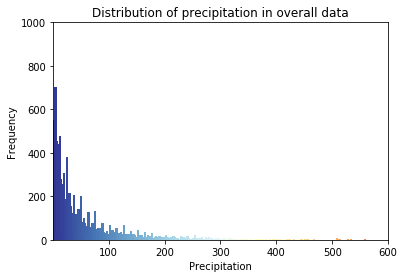

In [10]:
import matplotlib.pyplot as plt
#print tmp.shape, type(tmp)
# This is  the colormap I'd like to use.
# This is  the colormap I'd like to use.
cm = plt.cm.get_cmap('RdYlBu_r')
x_span = np.nanmax(list2)-np.nanmin(list2)

cleanedList1 = [] 
cleanedList2 = []
for x,y in zip(list1,list2): 
    if x > 1 and y!='nan' and y<=1000 and x<=1000:
        cleanedList1.append(x)
        cleanedList2.append(y)


C = [cm(((x-np.nanmin(cleanedList2))/x_span)) for x in cleanedList2]
plt.ylim([1, 1000])
plt.xlim([1, 600])

# print cleanedList1
# print cleanedList2
plt.bar(np.array(cleanedList2),np.array(cleanedList1),color=C,width=4.0);
plt.xlabel('Precipitation')
plt.ylabel('Frequency')
plt.title('Distribution of precipitation in overall data')
# for i in range(len(list1)):
#     plt.hlines(list1[i],0,list2[i]) 
plt.show()

In [11]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query1 = "SELECT * FROM (SELECT  station, year, vector, latitude, longitude, label, ROW_NUMBER() OVER(PARTITION BY station ORDER BY year) rn FROM weather WHERE measurement = 'TMAX') a WHERE rn = 1"
Query2 = "SELECT * FROM (SELECT  station, year, vector, latitude, longitude, label, ROW_NUMBER() OVER(PARTITION BY station ORDER BY year) rn FROM weather WHERE measurement = 'TMIN') a WHERE rn = 1"
#Query1="SELECT station, year, vector FROM weather WHERE measurement='TMAX'"
Query3 = "SELECT * FROM (SELECT  station, year, vector, latitude, longitude, label, ROW_NUMBER() OVER(PARTITION BY station ORDER BY year) rn FROM weather WHERE measurement = 'PRCP' AND station in ('USC00213727', 'CA006030488', 'USC00214191', 'CA006020559', 'CA006034075', 'CA006034070', 'USC00218763', 'USC00216929')) a WHERE rn = 1"
df1 = sqlContext.sql(Query1)
df1.show(2)
df2 = sqlContext.sql(Query2)
df2.show(2)
df3 = sqlContext.sql(Query3)
df3.show(2)
tempHot=df1.rdd.map(lambda row: (np.nanmax(unpackArray(row['vector'],np.float16)), (row['station'], row['year'], row['latitude'], row['longitude']))).reduceByKey(lambda x,y: x).sortByKey(False)
tempCold=df2.rdd.map(lambda row: (np.nanmin(unpackArray(row['vector'],np.float16)), (row['station'], row['year'], row['latitude'], row['longitude']))).reduceByKey(lambda x,y: x).sortByKey()

prcp=df3.rdd.map(lambda row: (np.nanmin(unpackArray(row['vector'],np.float16)), (row['station'], row['year'], row['latitude'], row['longitude'])))


+-----------+------+--------------------+--------+---------+--------+---+
|    station|  year|              vector|latitude|longitude|   label| rn|
+-----------+------+--------------------+--------+---------+--------+---+
|USC00215989|2009.0|[00 7E 30 D4 00 7...| 47.8358| -94.2556|BBSBSBSB|  1|
|USC00210643|1900.0|[E0 D0 00 7E 40 C...| 47.5369| -94.8297|BBSBSBSB|  1|
+-----------+------+--------------------+--------+---------+--------+---+
only showing top 2 rows

+-----------+------+--------------------+--------+---------+--------+---+
|    station|  year|              vector|latitude|longitude|   label| rn|
+-----------+------+--------------------+--------+---------+--------+---+
|USC00215989|2009.0|[00 7E A0 DB 00 7...| 47.8358| -94.2556|BBSBSBSB|  1|
|USC00210643|1900.0|[08 D9 00 7E 60 D...| 47.5369| -94.8297|BBSBSBSB|  1|
+-----------+------+--------------------+--------+---------+--------+---+
only showing top 2 rows

+-----------+------+--------------------+--------+---------+--

In [12]:
print(tempHot.take(10))
print(tempCold.take(10))

[(406.0, (u'USC00210746', 1931.0, 48.1969, -93.7994)), (389.0, (u'USC00215533', 1932.0, 47.95, -94.2167)), (383.0, (u'USC00219015', 1901.0, 46.3167, -92.8)), (378.0, (u'USC00216213', 1931.0, 48.0553, -92.8425)), (372.0, (u'USC00213411', 1911.0, 46.4119, -94.3608)), (361.0, (u'USC00213303', 1916.0, 47.2436, -93.4975)), (356.0, (u'USC00218543', 1911.0, 47.5, -92.55)), (350.0, (u'USC00214233', 1964.0, 47.9422, -94.4553)), (344.0, (u'USC00210643', 1900.0, 47.5369, -94.8297)), (340.0, (u'CA00602K300', 1981.0, 48.68, -93.83))]
[(-250.0, (u'USC00215989', 2009.0, 47.8358, -94.2556)), (-249.0, (u'CA006032120', 2005.0, 49.83, -92.74)), (-245.0, (u'CA00602K300', 1981.0, 48.68, -93.83)), (-244.0, (u'USC00214103', 1964.0, 46.3197, -93.5014)), (-239.0, (u'USC00215298', 1921.0, 46.9833, -92.7333)), (-233.0, (u'USC00213411', 1911.0, 46.4119, -94.3608)), (-183.0, (u'USC00212645', 1987.0, 47.4581, -92.5303))]


In [13]:
(min_long, max_long, min_lat, max_lat) = (-94.8297, -92.5253, 46.3197, 49.833)

In [14]:
tmp = tempHot.collect()
temp = tempCold.filter(lambda x: x[0] < 295).collect()
for t in temp:
    tmp.append(t)
# tmp = tempHot.collect()
# pdf=tempHot.toDF().toPandas()
# pdf.sort_values(by=['station'],inplace=True)
# pdf.head(2)


In [15]:
tmp

[(406.0, (u'USC00210746', 1931.0, 48.1969, -93.7994)),
 (389.0, (u'USC00215533', 1932.0, 47.95, -94.2167)),
 (383.0, (u'USC00219015', 1901.0, 46.3167, -92.8)),
 (378.0, (u'USC00216213', 1931.0, 48.0553, -92.8425)),
 (372.0, (u'USC00213411', 1911.0, 46.4119, -94.3608)),
 (361.0, (u'USC00213303', 1916.0, 47.2436, -93.4975)),
 (356.0, (u'USC00218543', 1911.0, 47.5, -92.55)),
 (350.0, (u'USC00214233', 1964.0, 47.9422, -94.4553)),
 (344.0, (u'USC00210643', 1900.0, 47.5369, -94.8297)),
 (340.0, (u'CA00602K300', 1981.0, 48.68, -93.83)),
 (339.0, (u'CA006034070', 1900.0, 49.8, -94.53)),
 (333.0, (u'USC00211630', 1912.0, 46.7047, -92.5253)),
 (330.0, (u'CA006020559', 1980.0, 48.63, -93.97)),
 (328.0, (u'CA006027825', 1970.0, 48.72, -94.42)),
 (322.0, (u'USR0000MBEM', 2004.0, 47.5033, -94.9281)),
 (317.0, (u'USC00215989', 2009.0, 47.8358, -94.2556)),
 (306.0, (u'CA006032119', 1971.0, 49.833, -92.75)),
 (300.0, (u'USR0000MBAU', 2004.0, 48.6703, -94.6172)),
 (295.0, (u'CA006026852', 1994.0, 48.72,

In [17]:
# feature = 'TMAX'
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex


m = []
for t in tmp:
    m.append(t[0])
#_min = min(np.array())
_min = np.min(m)
_max = np.max(m)


# _avg='avg(%s)'%feature
# _min=pdf[_avg].min()
# _max=pdf[_avg].max()
# _min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#800000'

In [18]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

In [19]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 6

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for row in tmp:
    print row 
    print str(get_color(row[0]))
    _lat=row[1][2]
    _long=row[1][3]
    t = (row[0]-350)
    _count=650 #np.abs(t * 5.5)
    _coef=row[0] 
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(400*np.sqrt(_count)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m 

(406.0, (u'USC00210746', 1931.0, 48.1969, -93.7994))
#800000
(389.0, (u'USC00215533', 1932.0, 47.95, -94.2167))
#9b0000
(383.0, (u'USC00219015', 1901.0, 46.3167, -92.8))
#a40000
(378.0, (u'USC00216213', 1931.0, 48.0553, -92.8425))
#ad0000
(372.0, (u'USC00213411', 1911.0, 46.4119, -94.3608))
#bb0000
(361.0, (u'USC00213303', 1916.0, 47.2436, -93.4975))
#cd0000
(356.0, (u'USC00218543', 1911.0, 47.5, -92.55))
#d60000
(350.0, (u'USC00214233', 1964.0, 47.9422, -94.4553))
#df0000
(344.0, (u'USC00210643', 1900.0, 47.5369, -94.8297))
#ed0400
(340.0, (u'CA00602K300', 1981.0, 48.68, -93.83))
#f10800
(339.0, (u'CA006034070', 1900.0, 49.8, -94.53))
#f60b00
(333.0, (u'USC00211630', 1912.0, 46.7047, -92.5253))
#ff1300
(330.0, (u'CA006020559', 1980.0, 48.63, -93.97))
#ff1600
(328.0, (u'CA006027825', 1970.0, 48.72, -94.42))
#ff1a00
(322.0, (u'USR0000MBEM', 2004.0, 47.5033, -94.9281))
#ff2200
(317.0, (u'USC00215989', 2009.0, 47.8358, -94.2556))
#ff2900
(306.0, (u'CA006032119', 1971.0, 49.833, -92.75))
#

### Script for plotting yearly plots

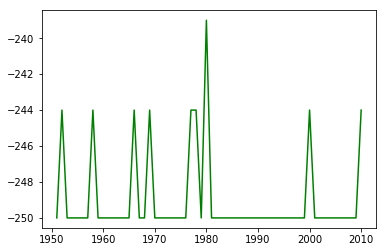

In [180]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT year, vector FROM weather\n\tWHERE measurement='%s' and station='%s'"%('SNWD','USC00211630')
Query1="SELECT year, vector FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00211630')
Query2="SELECT year, vector FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USC00211630')
Query3="SELECT year, vector FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMIN','USC00211630')

df1 = sqlContext.sql(Query)
df2 = sqlContext.sql(Query1)
df3 = sqlContext.sql(Query2)
df4 = sqlContext.sql(Query3)

#print df1.count(),'rows'
#df1.show(50)
years = df1.rdd.map(lambda row: row['year']).collect()[:60]
s=df1.rdd.map(lambda row:np.nanmean(unpackArray(row['vector'],np.float16))).collect()[:60]
p=df2.rdd.map(lambda row:np.nanmean(unpackArray(row['vector'],np.float16))).collect()[:60]
tmax=df3.rdd.map(lambda row:np.nanmax(unpackArray(row['vector'],np.float16))).collect()[:60]
tmin=df4.rdd.map(lambda row:np.nanmin(unpackArray(row['vector'],np.float16))).collect()[:60]

s=np.vstack(s)
p=np.vstack(p)
tmax=np.vstack(tmax)
tmin=np.vstack(tmin)
# print tmax
import matplotlib.pyplot as plt
# plt.plot(years,s ,'b-')
# plt.plot(years,p ,'r-')
# plt.plot(years,tmax ,'g-')
plt.plot(years,tmin ,'g-')
#plt.axis([0, 6, 0, 20])
plt.show()

In [215]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USW00093139')
Query1="SELECT DISTINCT station, year, vector FROM weather\n\tWHERE measurement='SNWD'"

Query2 = "SELECT * FROM (SELECT  station, year, vector, ROW_NUMBER() OVER(PARTITION BY station ORDER BY year) rn FROM weather WHERE measurement = 'SNWD') a WHERE rn = 1"

print Query
df1 = sqlContext.sql(Query)
df2 = sqlContext.sql(Query2)

print df1.count(),'rows'
df1.show(2)
df2.show(10)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16))
T=np.vstack(rows.collect())
T=T/10.  # scaling to make the temperature be in centingrates
print T

shape(T)



SELECT * FROM weather
	WHERE measurement='TMAX' and station='USW00093139'
63 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1478.3| 34.2325|-111.3447|       TMAX|USW00093139|     3|[40 56 20 50 E0 D...|1949.0|SSSSBBSS|
|   1478.3| 34.2325|-111.3447|       TMAX|USW00093139|     0|[50 57 E0 55 00 5...|1950.0|SSSSBBSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows

+-----------+------+--------------------+---+
|    station|  year|              vector| rn|
+-----------+------+--------------------+---+
|USC00023448|1916.0|[00 7E 00 00 00 0...|  1|
|USC00023501|2010.0|[00 00 00 00 00 0...|  1|
|USC00294101|1907.0|[00 00 00 00 00 0...|  1|
|USC00297191|1987.0|[00

(63, 365)

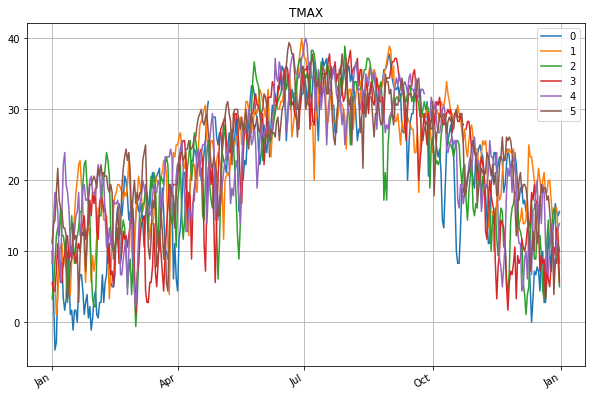

In [216]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:6,:].transpose(),fig,ax,title='TMAX')

#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [9]:
print((STAT['PRCP']['NE']))

[ 2518.  2522.  2524.  2528.  2521.  2527.  2534.  2540.  2535.  2537.
  2531.  2530.  2533.  2533.  2531.  2531.  2518.  2528.  2526.  2532.
  2523.  2521.  2534.  2534.  2538.  2531.  2525.  2534.  2532.  2528.
  2532.  2548.  2543.  2545.  2548.  2547.  2539.  2529.  2528.  2533.
  2531.  2539.  2534.  2529.  2528.  2535.  2536.  2547.  2549.  2536.
  2539.  2533.  2538.  2550.  2543.  2544.  2544.  2543.  2543.  2523.
  2525.  2540.  2536.  2533.  2538.  2538.  2538.  2536.  2541.  2537.
  2536.  2541.  2540.  2544.  2542.  2543.  2542.  2539.  2544.  2545.
  2542.  2543.  2542.  2535.  2534.  2528.  2529.  2534.  2535.  2537.
  2544.  2541.  2544.  2545.  2542.  2543.  2546.  2546.  2552.  2547.
  2550.  2548.  2550.  2551.  2546.  2546.  2547.  2551.  2547.  2546.
  2549.  2549.  2550.  2549.  2553.  2549.  2553.  2553.  2550.  2544.
  2544.  2544.  2545.  2541.  2546.  2546.  2548.  2542.  2549.  2547.
  2546.  2543.  2540.  2543.  2539.  2541.  2549.  2544.  2543.  2545.
  2547

In [217]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/Users/digvijaykaramchandani/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


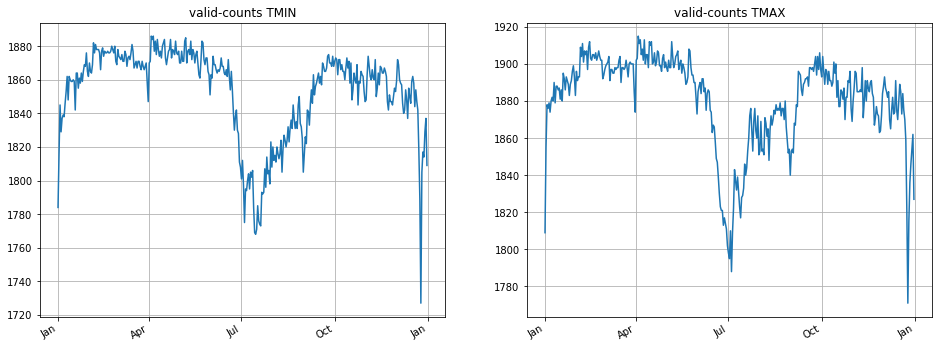

In [218]:
plot_pair(['TMIN','TMAX'],plot_valid)

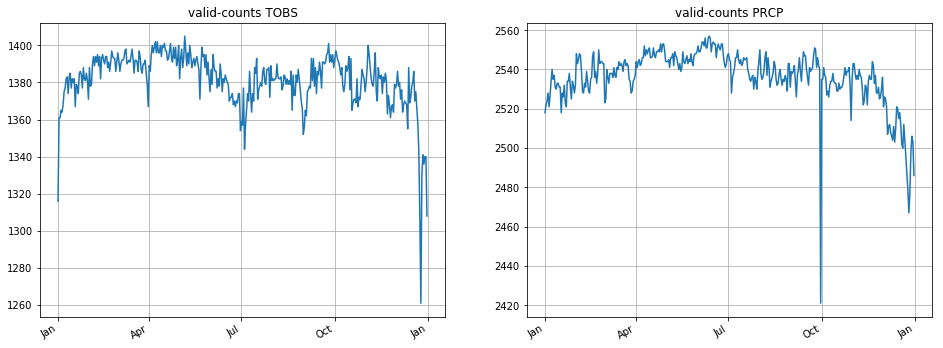

In [219]:
plot_pair(['TOBS','PRCP'],plot_valid)

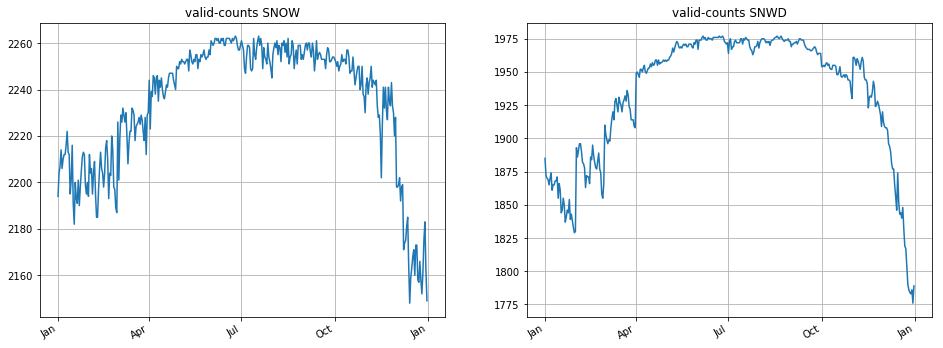

In [220]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [221]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

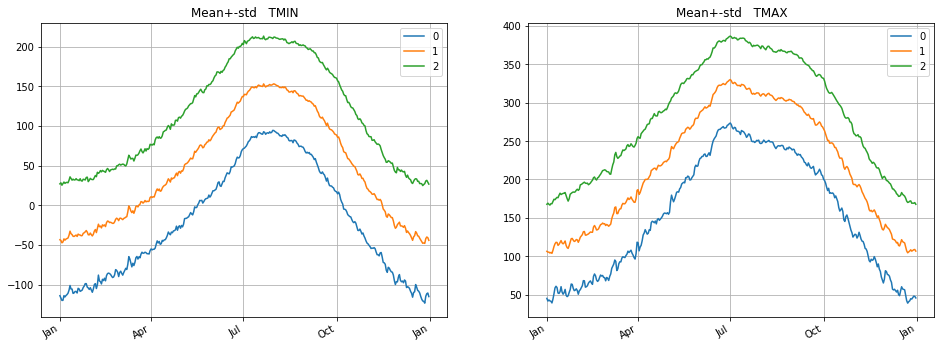

In [222]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

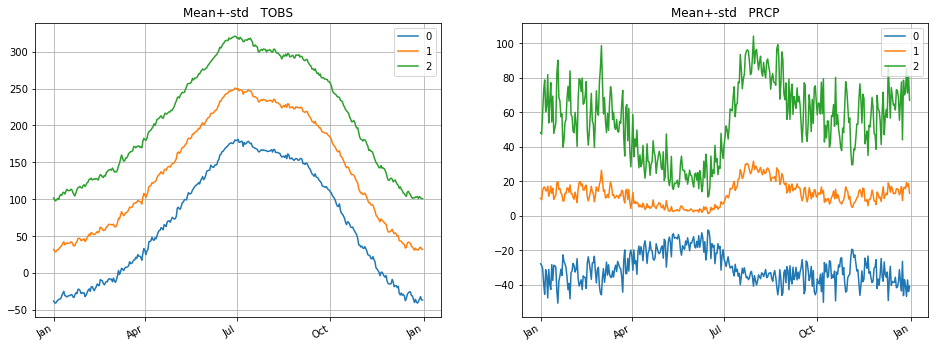

In [223]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

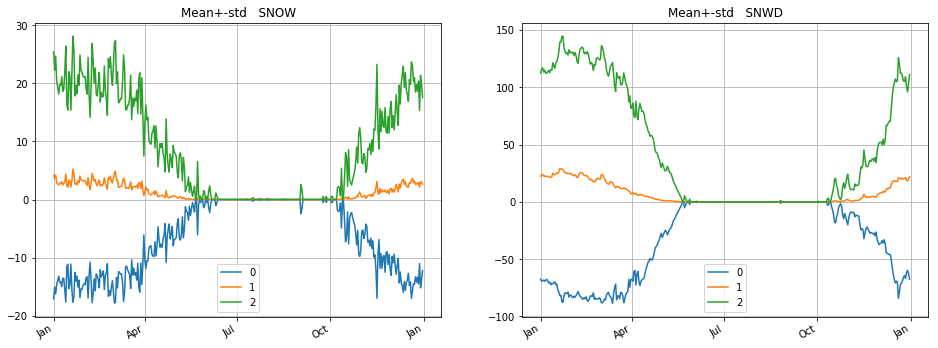

In [224]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [225]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

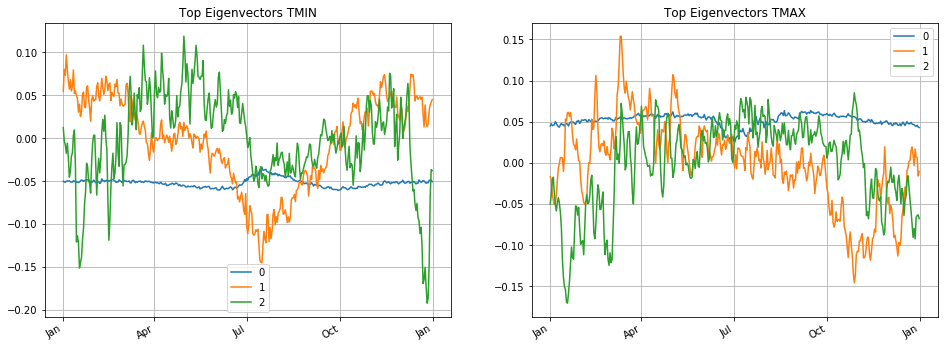

In [226]:
plot_pair(['TMIN','TMAX'],plot_eigen)

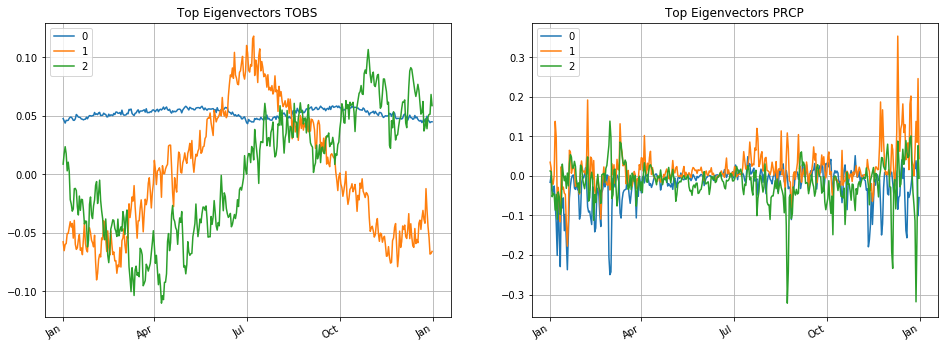

In [227]:
plot_pair(['TOBS','PRCP'],plot_eigen)

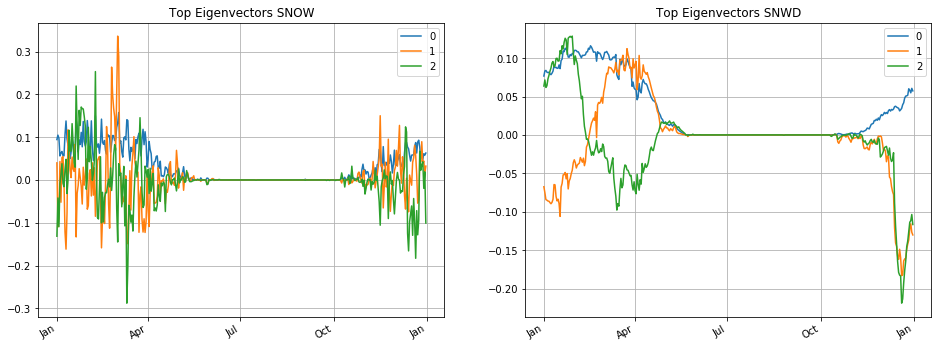

In [228]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [229]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

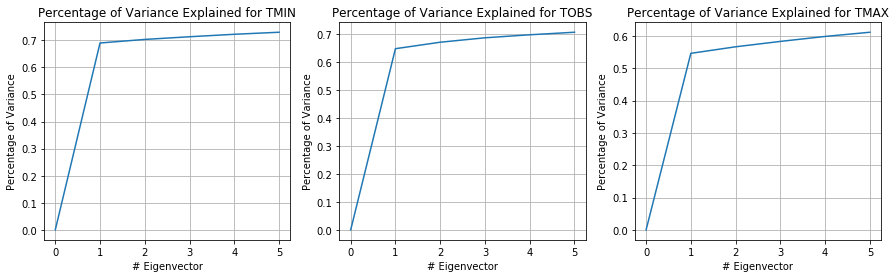

In [230]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

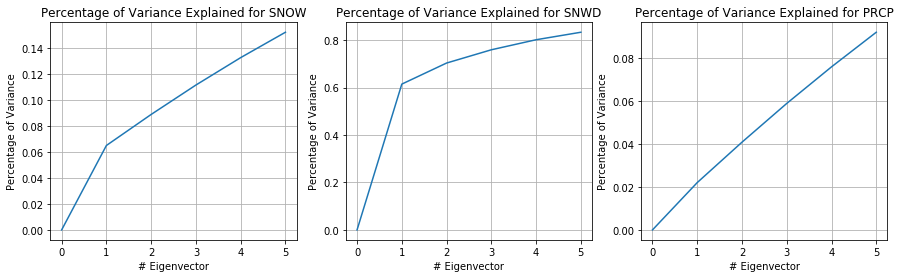

In [231]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()